In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from modules.numeric import *

In [4]:
phi4 = Phi4()

L = 200
N = 2048
DX = 2*L/(N - 1)
DT = 4e-2
X0 = 10

def init(x, v):
    return np.stack((
        phi4.kink(x + X0, 0, v) - phi4.kink(x - X0, 0, -v) - 1,
        phi4.kink_dt(x + X0, 0, v) - phi4.kink_dt(x - X0, 0, -v)
    ))

In [10]:
collider = Wave(
    x_grid= (-L, L, N), 
    dt= DT, 
    order= 4,
    y0= init,
    F= phi4.diff,
    boundaries=[Reflective(4)]*2,
    integrator= 'rk4',
)

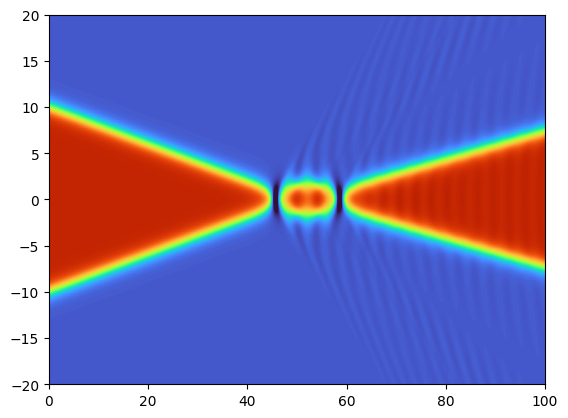

In [14]:
grid, Y = collider.run(100, v=0.2)
plt.imshow(Y[:, 0].T, cmap='turbo', vmin=-1.25, vmax=1.25, extent=grid.extent(), aspect='auto', origin='lower', interpolation='sinc')
plt.ylim(-20, 20)
plt.show()

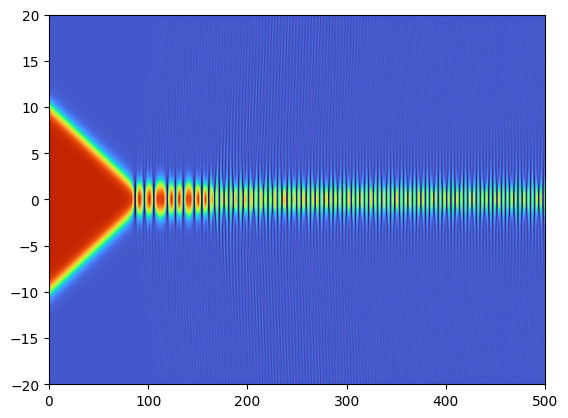

In [16]:
v = 0.1
grid, Y = collider.run(X0/v + 2*L, v=v)
plt.imshow(Y[:, 0].T, cmap='turbo', vmin=-1.25, vmax=1.25, extent=grid.extent(), aspect='auto', origin='lower', interpolation='sinc')
plt.ylim(-20, 20)
plt.show()

In [17]:
np.array([
    (1, 0),
    (0, 1)
]).T

array([[1, 0],
       [0, 1]])